# Analysis of daily individual dog performance

## Data import and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

/tmp/ipykernel_11144/3100000271.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('races.csv')
df = df[df.team1.str.startswith('Wild')]
df = df.replace('unknown', np.nan)
df.when = pd.to_datetime(df.when)
df.head(2)

,division,when,team1,team2,time_tot,win,hurdles,name1,start_chng1,time1,name2,start_chng2,time2,name3,start_chng3,time3,name4,start_chng4,time4,event,course_color
0,1,2023-04-22 10:11:57,WildRunners dreamers,WildRunners Maximini,17.01,L,25.0,Sunny,-0.24,4.21,Dixie,0.30,4.24,Alex,0.16,4.22,Hector,0.0,4.13,Hanácké škvarek (Heroltice),blue
1,1,2023-04-22 10:11:57,WildRunners Maximini,WildRunners dreamers,19.43,L,25.0,Brooke,-0.11,4.08,Rocky,1.29,5.15,Bella,0.23,4.52,Bree,0.0,4.28,Hanácké škvarek (Heroltice),red


In [4]:
df_run1 = df[['when', 'name1', 'start_chng1', 'time1']]
df_run2 = df[['when', 'name2', 'start_chng2', 'time2']]
df_run3 = df[['when', 'name3', 'start_chng3', 'time3']]
df_run4 = df[['when', 'name4', 'start_chng4', 'time4']]

col_names = ['when', 'name', 'start_chng', 'time']
df_run1.columns = col_names
df_run2.columns = col_names
df_run3.columns = col_names
df_run4.columns = col_names

df_run1 = df_run1.dropna()
df_run2 = df_run2.dropna()
df_run3 = df_run3.dropna()
df_run4 = df_run4.dropna()

df_runs_234 = pd.concat([df_run2, df_run3, df_run4], axis=0)

df_runs_all = pd.concat([df_run1, df_run2, df_run3, df_run4], axis=0)
df_runs_all['time'] = pd.to_numeric(df_runs_all['time'], errors='coerce')
df_runs_all = df_runs_all.dropna()
df_runs_all = df_runs_all[df_runs_all.time <= 8]
df_runs_all = df_runs_all[df_runs_all.start_chng <= 8]
df_runs_all['total_time'] = np.where(df_runs_all.start_chng >= 0, df_runs_all.time + df_runs_all.start_chng, None)
df_runs_all.shape

(4340, 5)

In [5]:
days = pd.Series(np.sort(df_runs_all.when.dt.date.unique()))
diff = days.diff().dt.days.fillna(0)

df_day_diff = pd.DataFrame({
    'date': days,
    'diff': diff
})
second_days = df_day_diff[df_day_diff['diff'] == 1]['date']
second_days

df_runs_all['2nd_day'] = df_runs_all.when.dt.date.isin(second_days)
df_runs_all.shape

(4340, 6)

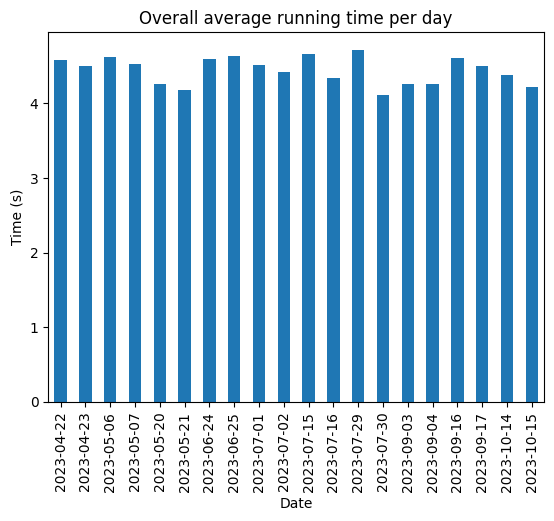

In [6]:
df_runs_all.groupby(df_runs_all.when.dt.date).time.mean().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Time (s)')
plt.title('Overall average running time per day')
plt.show()

## Function definitions

In [7]:
def most_runs(df, date):
    temp = df[df.when.dt.date == date]
    return temp.name.value_counts()[:7]

In [8]:
def fastest_runers(df, date):
    temp = df[df.when.dt.date == date]
    return temp.groupby('name').time.mean().sort_values()[:7]

In [9]:
def best_overall(df, date):
    temp = df[df.when.dt.date == date]
    temp = temp.dropna()
    return temp.groupby('name').total_time.mean().sort_values()[:7]

In [10]:
def fastest_starters(df, date):
    temp = df[df.when.dt.date == date]
    temp = temp[temp.start_chng >= 0]
    return temp.groupby('name').start_chng.mean().sort_values()[:7]

In [11]:
def good_starters(df, date):
    temp = df[df.when.dt.date == date]
    
    dogs = pd.DataFrame({
        'name': temp.name.unique(),
        'runs': 0,
        'good': 0,
        'wrong': 0
    })
    dogs = dogs.set_index('name')

    for _, row in temp.iterrows():
        when, name, start_chng, time, _, _2 = row
        dogs.loc[name, 'runs'] += 1
        if start_chng < 0:
            dogs.loc[name, 'wrong'] += 1
        else:
            dogs.loc[name, 'good'] += 1

    dogs['wrong_ratio'] = dogs.wrong / dogs.runs * 100
    dogs = dogs[dogs.runs >= 5]

    return dogs.sort_values('wrong_ratio')[:7]

In [12]:
top_2_any_day = set()

for day in days:
    top_2_any_day.update(best_overall(df_runs_all, day)[:2].index)

top_2_any_day

{'Alfie',
 'Bree',
 'Brooke',
 'Cookies',
 'Enola',
 'Maggie',
 'Moon',
 'Pax',
 'Sunny',
 'Tyna'}

## Most running dogs per day

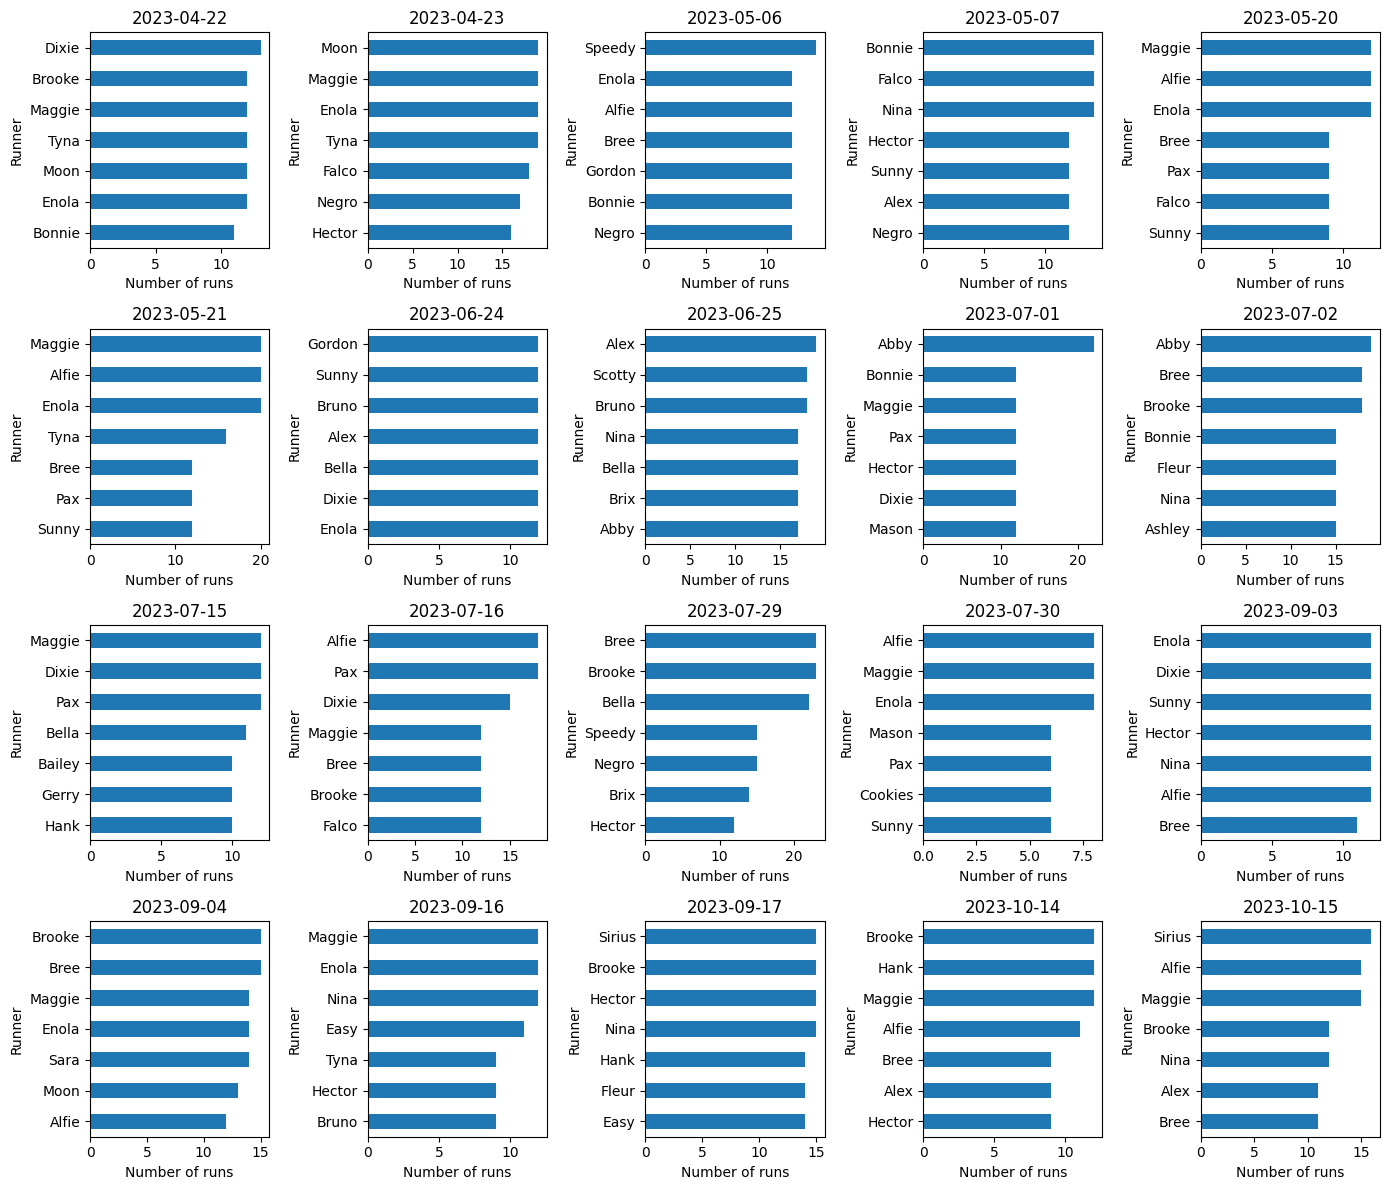

In [13]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    most_runs(df_runs_all, day).sort_values().plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('Runner')
    ax.set_xlabel('Number of runs')

plt.tight_layout()
plt.show()


## Best total times per day

Showing the top seven dogs in terms of average total time (run time + start time or change time)

Only the runs with correct start / change are taken into account

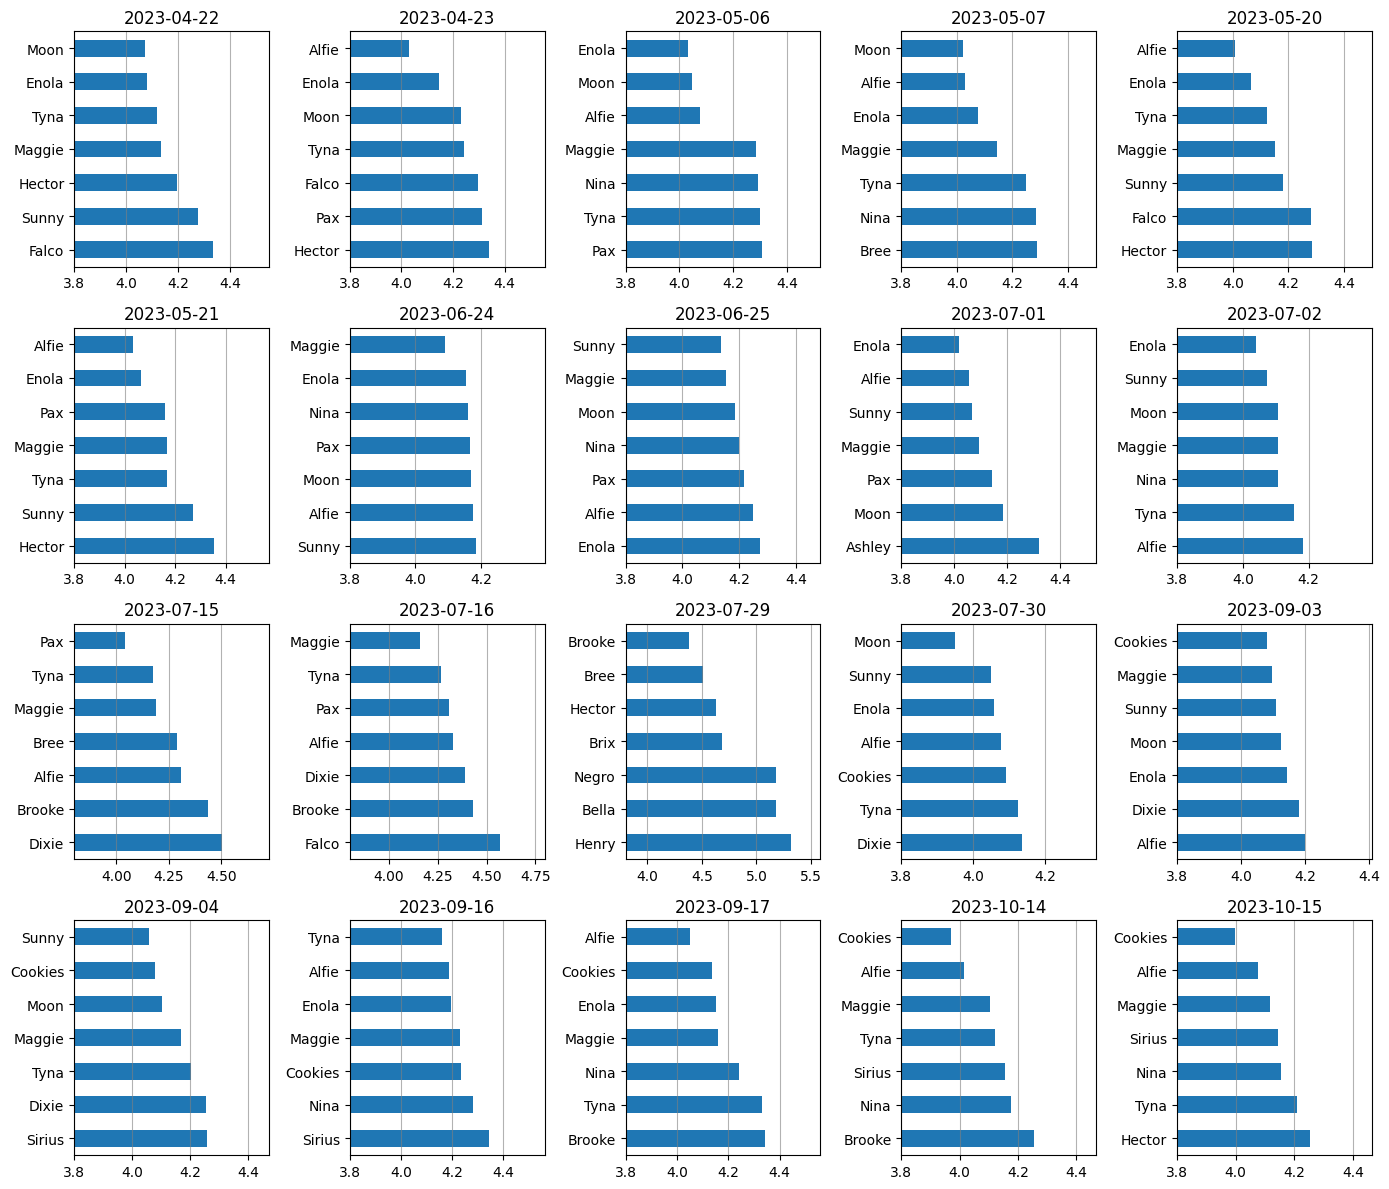

In [14]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    best_overall(df_runs_all, day).sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.set_xlim(3.8,)
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Fastest dogs per day

Only the runtime is taken into account

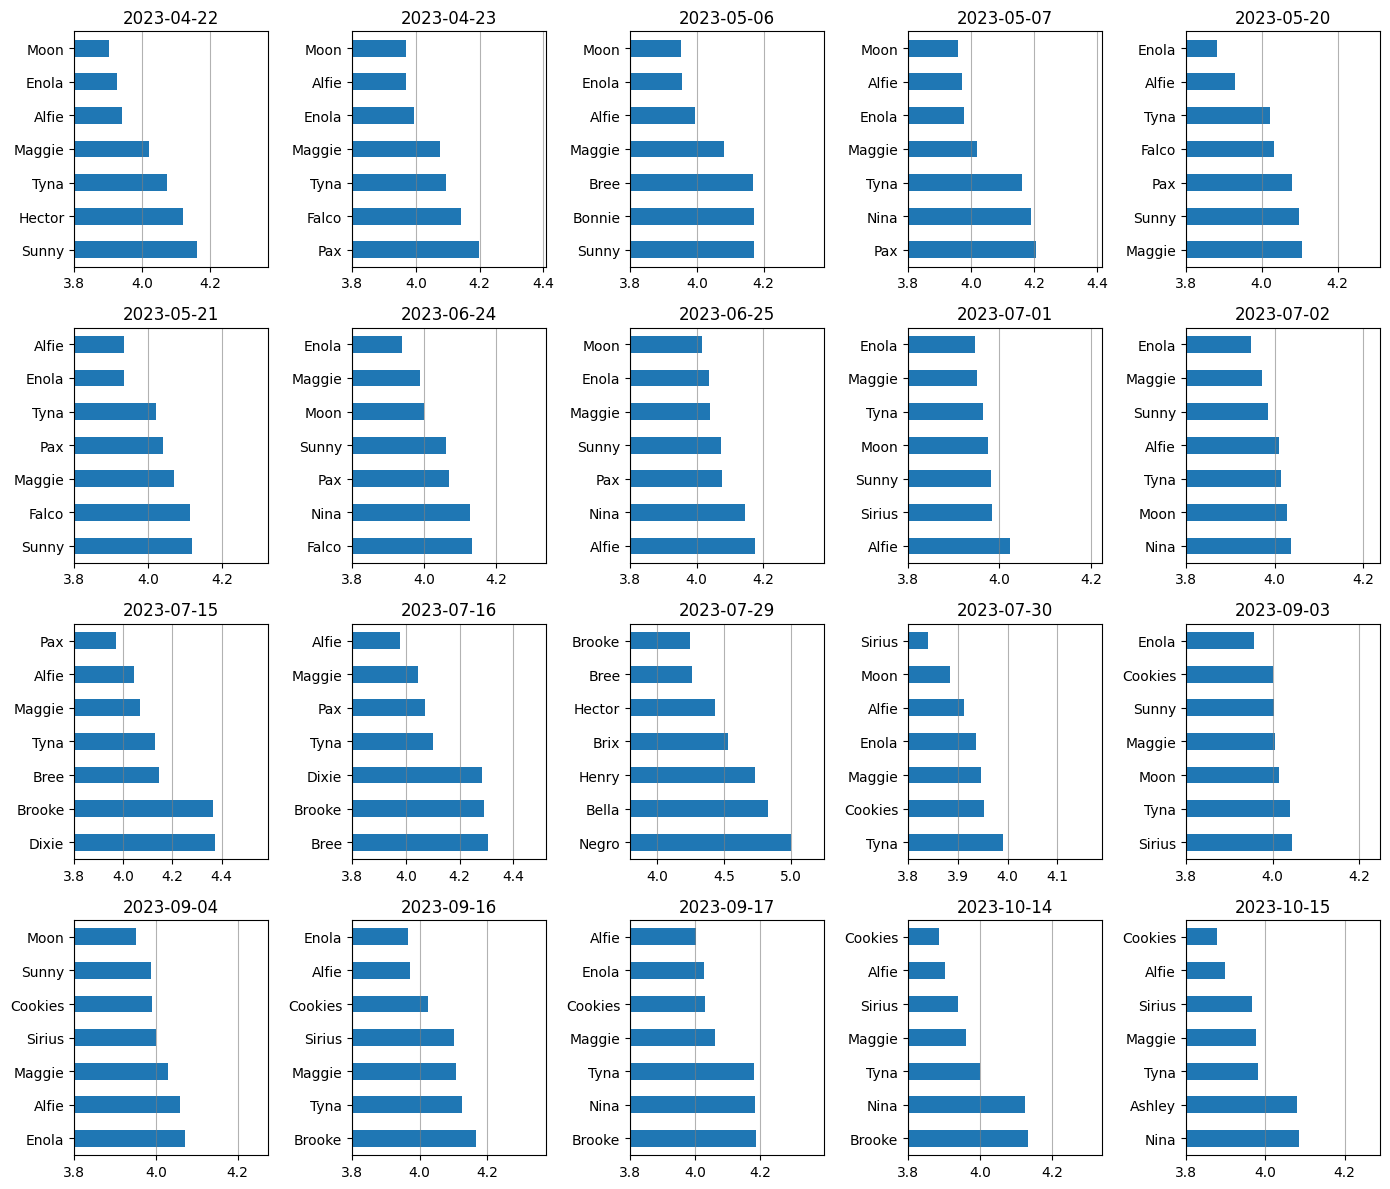

In [15]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    fastest_runers(df_runs_all, day).sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.set_xlim(3.8,)
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Best starters per day

Taking only good starts into account

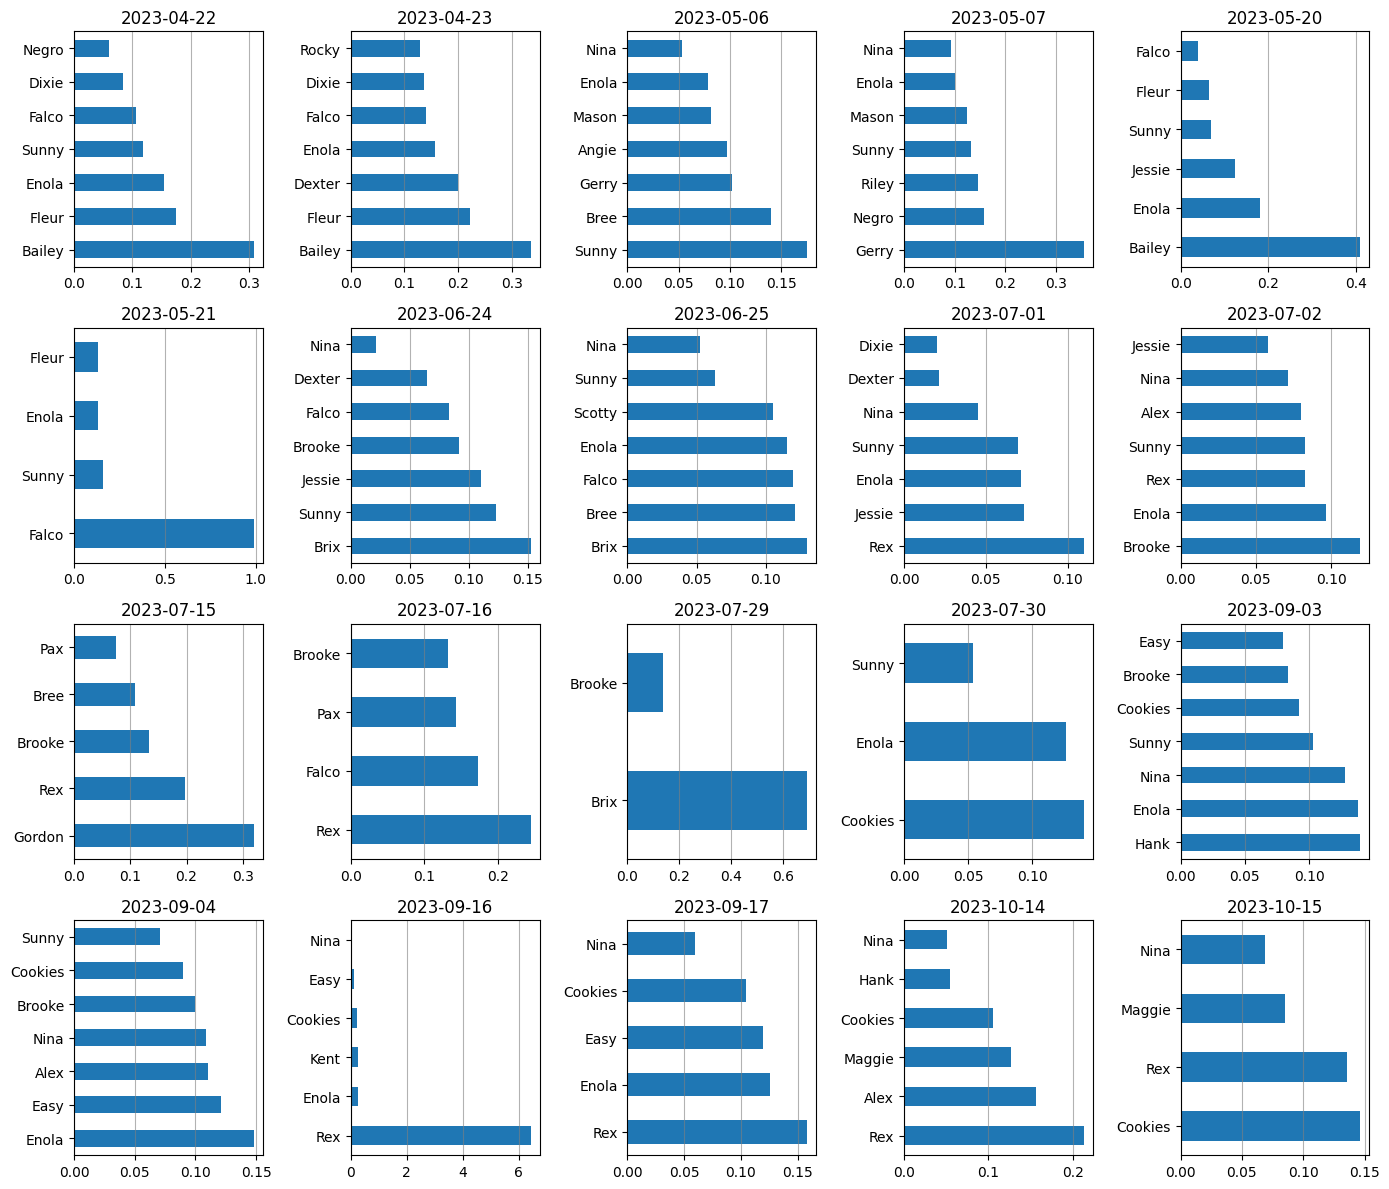

In [16]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    fastest_starters(df_run1, day).sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Best changers per day

Taking only good changes into account

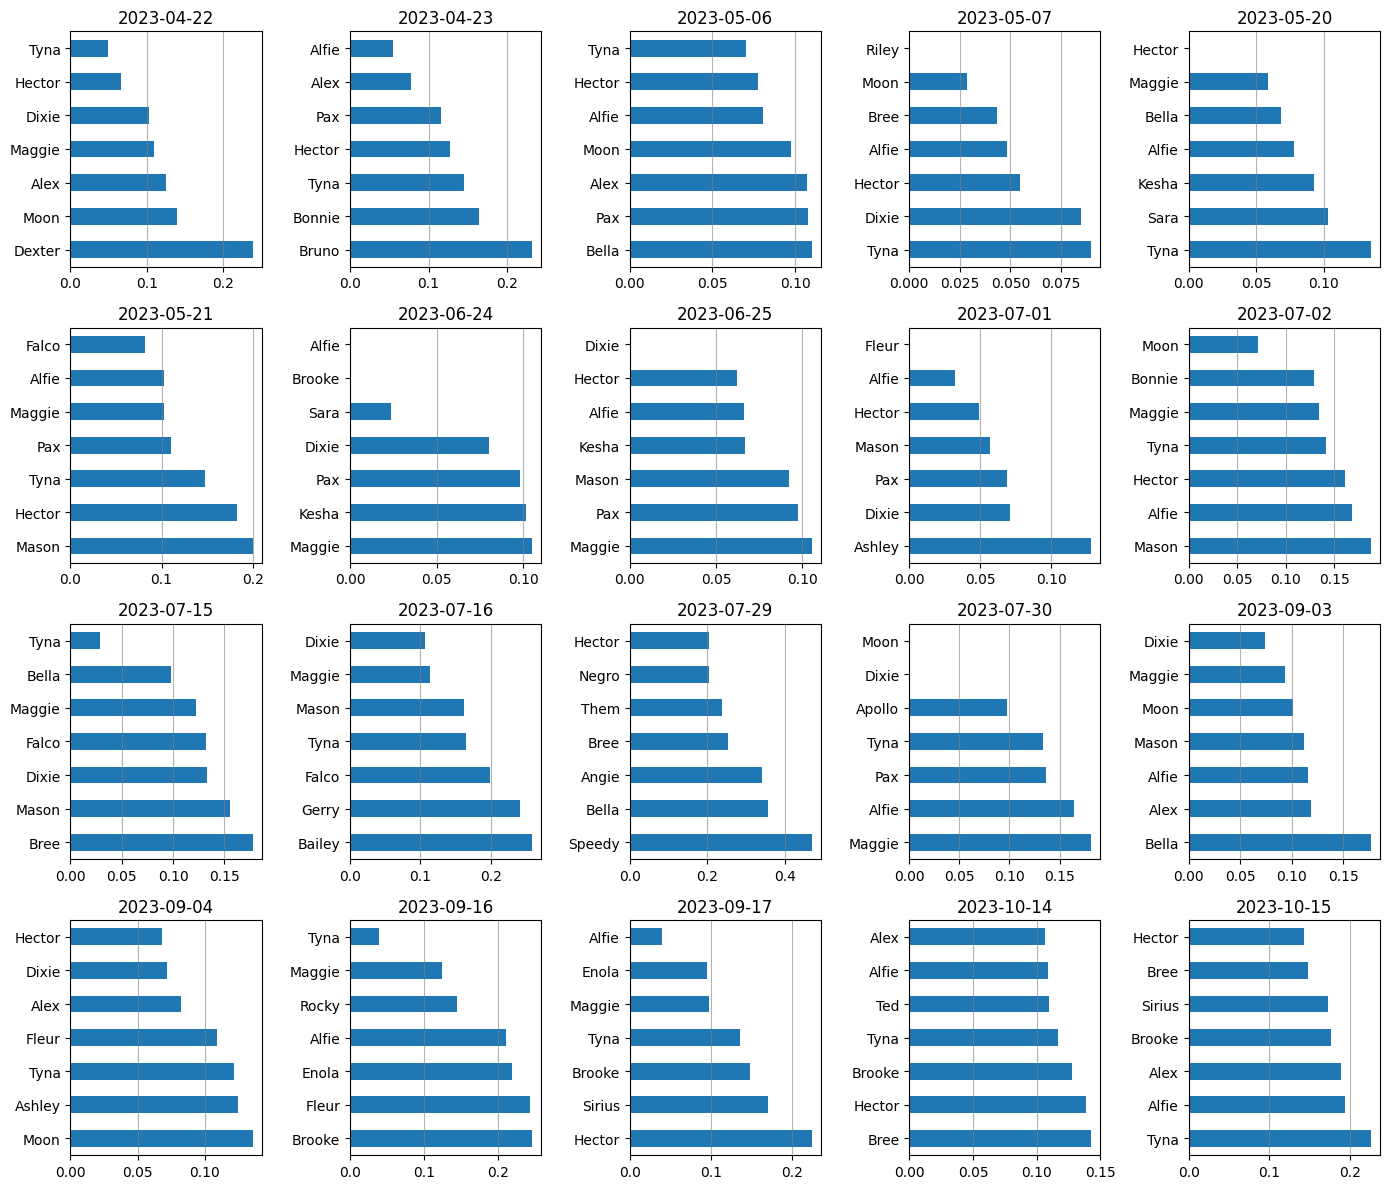

In [17]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    fastest_starters(df_runs_234, day).sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Wrong start/change ratios per day

Showing the top seven dogs with the lowest wrong start / change ratios in percentage 

Only dogs with at least 5 runs are taken into account

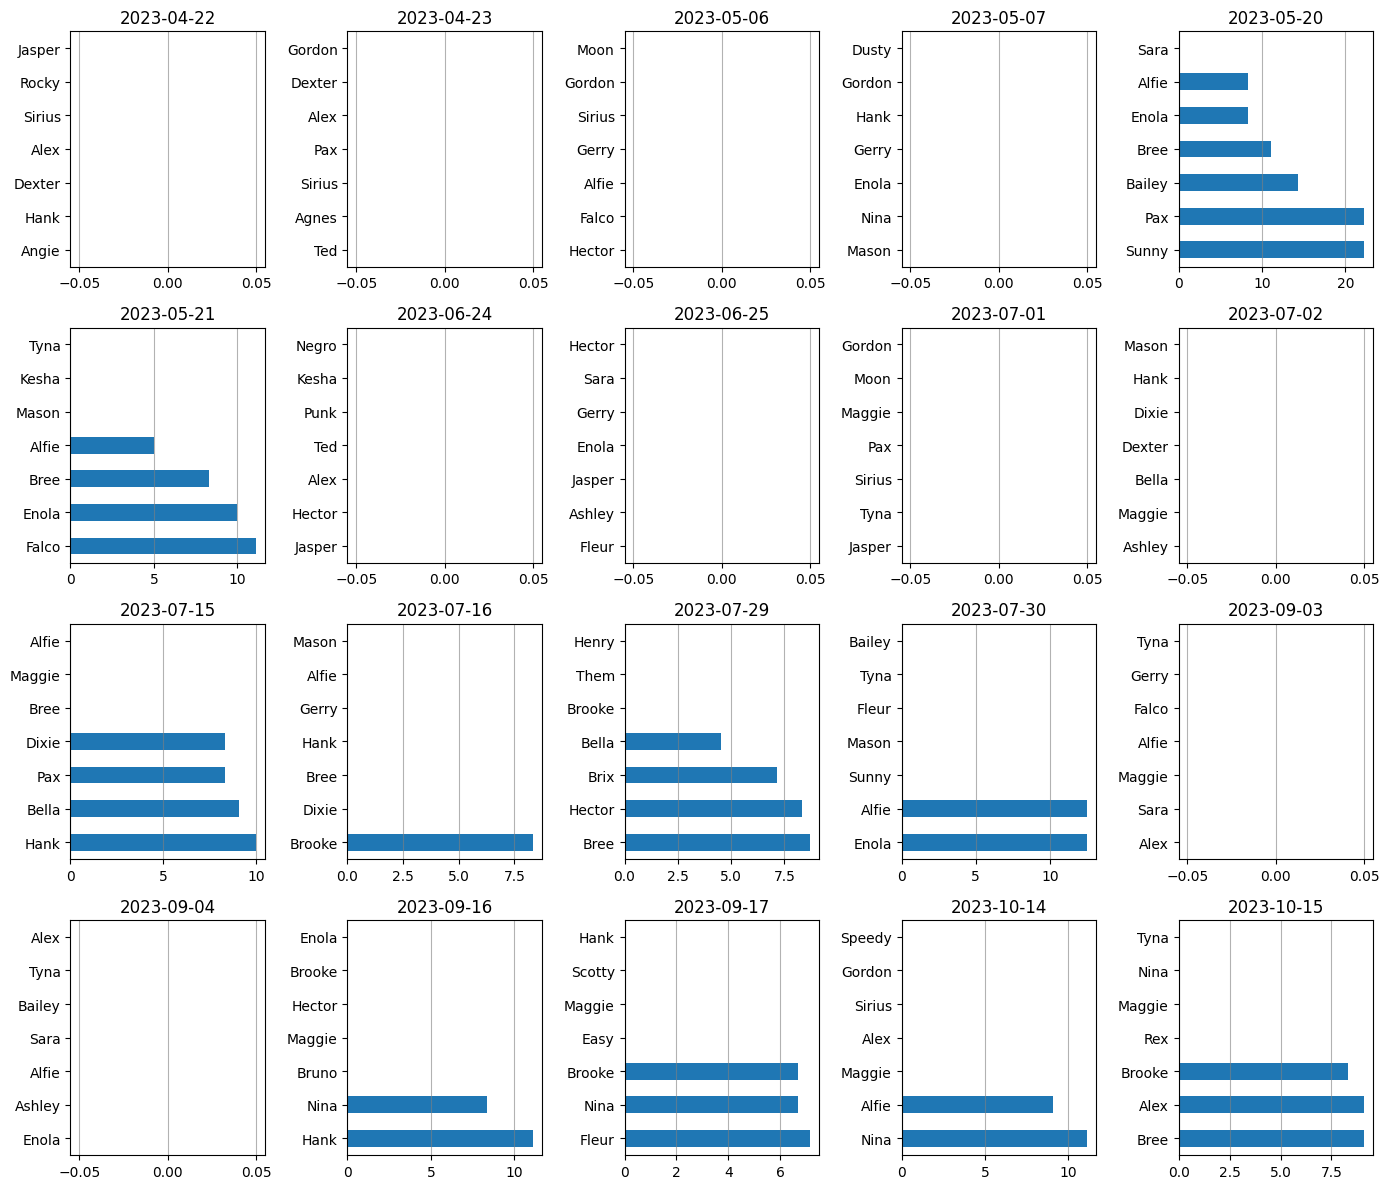

In [18]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    good_starters(df_runs_all, day).wrong_ratio.sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Performance difference between first day and second day

Every competion in our data set is two days long. Below is average perfomrance of each dog during the 1st and 2nd days. 

For easier readability, I took only the best performing dogs into account (The top two performers of each day combined)

I do not see any meaningful difference. Most dogs' performance are basically the same on both days.

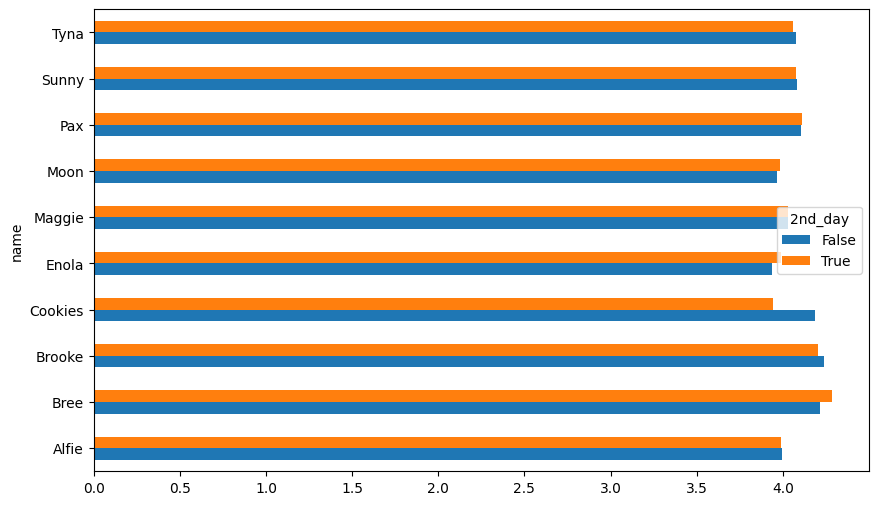

In [19]:
df_runs_all[df_runs_all.name.isin(top_2_any_day)].groupby(['name', '2nd_day']).time.mean().unstack().plot(kind='barh', figsize=(10, 6));

## Dog ranking

Each dog every day can collect points.

For a daily average in total time (including run time + start/change time):
- avg. total time < 4.0 secs:  3 points
- avg. total time < 4.1 secs:  2 points
- avg. total time < 4.2 secs:  1 point

<Axes: ylabel='name'>

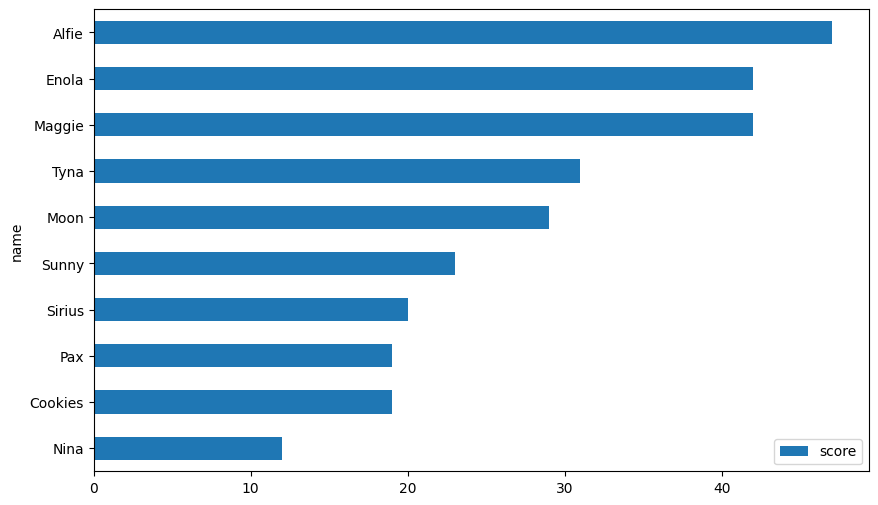

In [20]:
scores = {name: 0 for name in df_runs_all.name.unique()}

for day in days:
    temp = df_runs_all[df_runs_all.when.dt.date == day]
    times = temp.groupby('name').time.mean().sort_values()
    for name, time in times.items():
        if time < 4.0:
            scores[name] += 3
        elif time < 4.1:
            scores[name] += 2
        elif time < 4.2:
            scores[name] += 1

df_scores = pd.DataFrame(scores.items(), columns=['name', 'score']).sort_values('score', ascending=True)
df_scores.set_index('name').tail(10).plot(kind='barh', figsize=(10, 6))

